<a href="https://colab.research.google.com/github/Wnn61/1140417/blob/main/%E3%80%8C%E9%9D%9E%E7%9B%A3%E7%9D%A3%E5%BC%8F%E5%AD%B8%E7%BF%92_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 機器學習實戰 (四)：非監督式學習

**授課老師：輔仁大學經濟系 Bruce (邱翊展) 老師**

這份 Colab Notebook 是搭配課程投影片 **(Lecture 5) 非監督式學習** 的實作講義。在學會了如何進行分類和迴歸之後，現在我們要進入機器學習的另一個重要領域：**非監督式學習 (Unsupervised Learning)**。

**學習目標：**
1.  理解非監督式學習與監督式學習的差異，以及其在商業上的應用場景。
2.  掌握三大核心技術：**分群分析 (Clustering)**、**降維 (Dimensionality Reduction)**、**異常檢測 (Anomaly Detection)**。
3.  實作並比較多種聚類演算法：K-means、階層式聚類 (Hierarchical Clustering)、DBSCAN。
4.  學習使用手肘法 (Elbow Method) 和輪廓係數 (Silhouette Score) 來選擇最佳的群組數量。
5.  使用 PCA 和 t-SNE 進行降維與視覺化。
6.  **【本章重點】** 將非監督式學習應用於真實的金融和商業場景：
    * 信用卡客戶分群
    * 異常交易檢測
    * 投資組合分析

---

**💡 核心概念：什麼是非監督式學習？**

與監督式學習最大的不同在於，**非監督式學習的資料沒有標籤 (Label)**。我們不告訴模型「這是好客戶」或「這是壞客戶」，而是讓模型自己去發現資料中隱藏的結構和模式。

**類比：**
- **監督式學習**：像是有答案的考卷，老師告訴你哪些題目答對、哪些錯了，你從中學習規律。
- **非監督式學習**：像是拿到一堆沒有分類的照片，你需要自己找出「這些照片可以怎麼分組」，沒有標準答案。

**主要應用：**
1. **分群 (Clustering)**：客戶分群、市場區隔
2. **降維 (Dimensionality Reduction)**：資料視覺化、特徵提取
3. **異常檢測 (Anomaly Detection)**：信用卡盜刷、網路攻擊

## 📝 Part 0: 環境設定與資料準備

我們將匯入必要的函式庫，並載入本次要使用的「**信用卡客戶資料集 (Credit Card Dataset)**」。

* **資料來源:** Kaggle - Credit Card Dataset for Clustering
* **目標:** 根據客戶的消費行為進行分群，找出不同的客戶類型
* **特徵:** `BALANCE`, `PURCHASES`, `CREDIT_LIMIT`, `PAYMENTS` 等 17 個特徵

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn 聚類演算法
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 評估指標
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# 設定圖表風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ 函式庫載入完成！")

✅ 函式庫載入完成！


In [ ]:
# Colab 進行 matplotlib 繪圖時顯示繁體中文
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib
matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

print("✅ 中文字型設定完成！")

--2025-11-27 05:55:28--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.195.138, 173.194.195.113, 173.194.195.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-11-27 05:55:28--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.184.132, 2607:f8b0:4001:c66::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-11-27 

In [ ]:
# 從 Kaggle 下載資料集 (或使用本地檔案)
df = pd.read_csv('https://raw.githubusercontent.com/daniel-bss/credit-card-clustering/main/CC%20GENERAL.csv', index_col = 'CUST_ID')


In [ ]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CRED

## 📊 Part 1: 探索性資料分析 (EDA) 與資料預處理

在進行聚類分析之前，我們需要先了解資料的分布特性，並進行必要的預處理。

In [ ]:
# 移除不需要的欄位 (如客戶ID) 和處理缺失值
if 'CUST_ID' in df.columns:
    df = df.drop('CUST_ID', axis=1)

# 移除 Cluster 欄位 (如果存在)，因為我們要自己進行聚類
if 'Cluster' in df.columns:
    df = df.drop('Cluster', axis=1)

# 處理缺失值 - 用中位數填補
df = df.fillna(df.median())

print("--- 清理後的資料集 ---")
print(f"資料筆數: {df.shape[0]}")
print(f"特徵數量: {df.shape[1]}")
print(f"缺失值總數: {df.isnull().sum().sum()}")
print("\n✅ 資料清理完成！")

--- 清理後的資料集 ---
資料筆數: 8950
特徵數量: 17
缺失值總數: 0

✅ 資料清理完成！


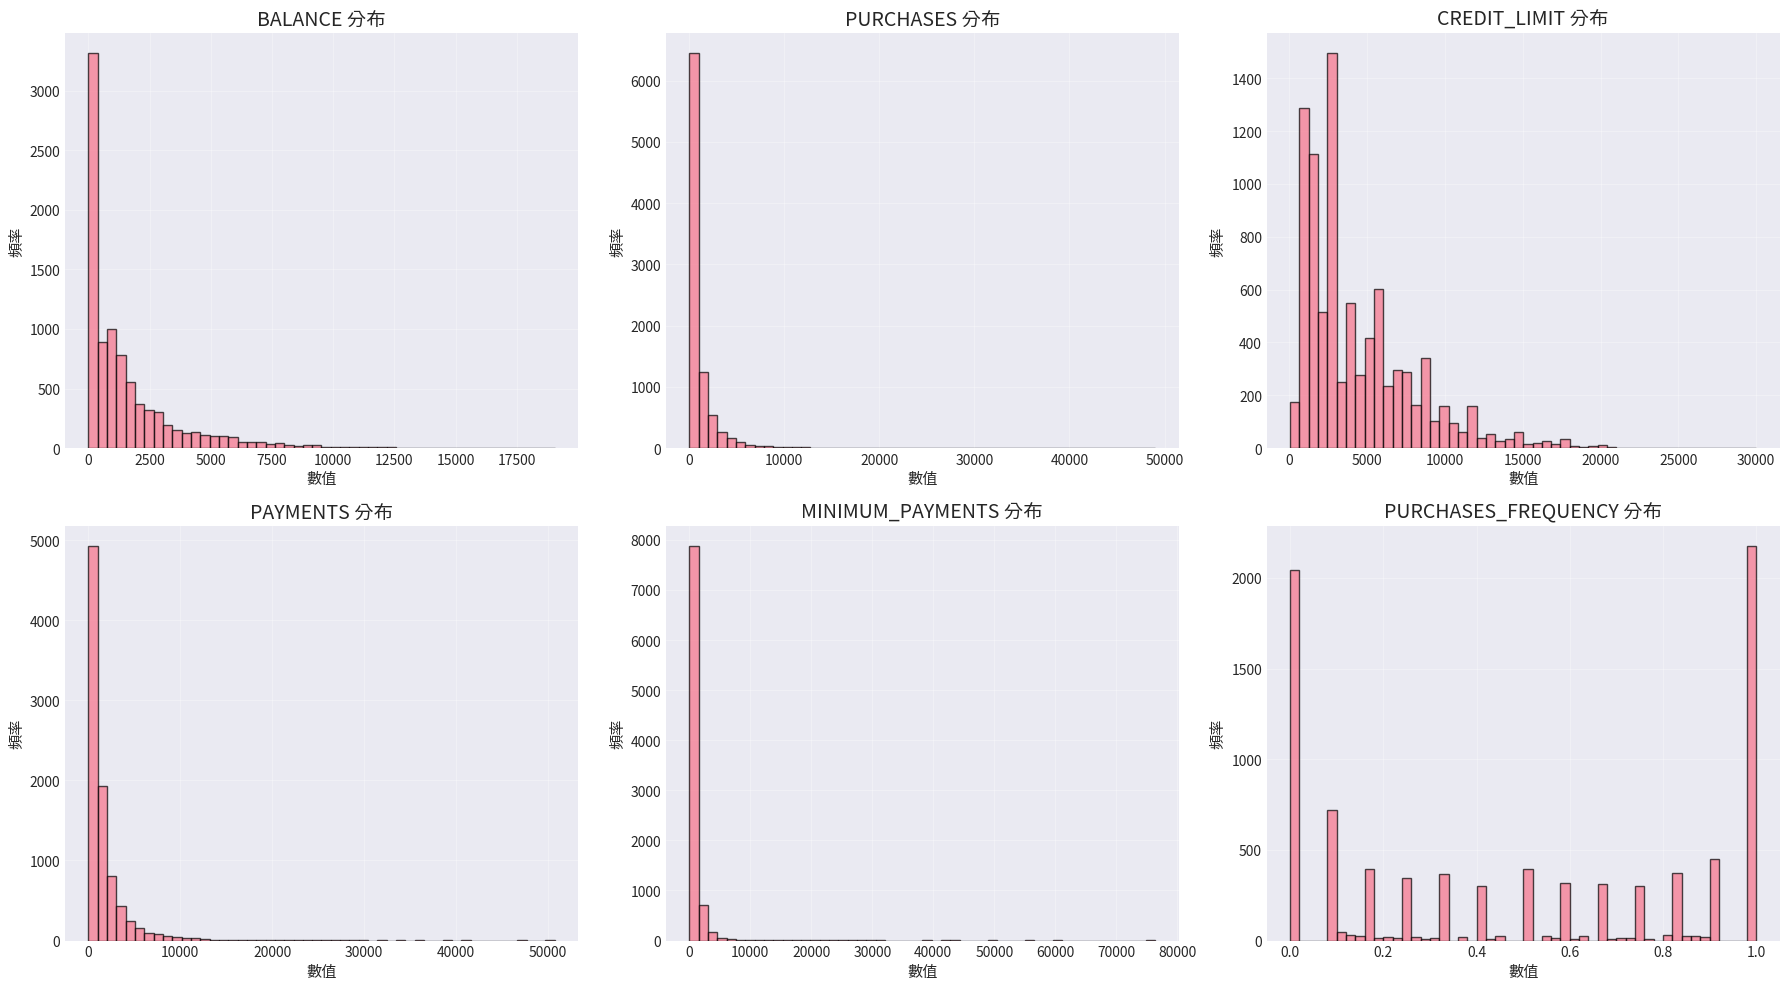

💡 觀察：大部分特徵呈現右偏分布，表示有少數高消費客戶


In [ ]:
# 選擇幾個重要特徵進行視覺化
key_features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS',
                'MINIMUM_PAYMENTS', 'PURCHASES_FREQUENCY']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if col in df.columns:
        axes[idx].hist(df[col], bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col} 分布', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('數值', fontsize=11)
        axes[idx].set_ylabel('頻率', fontsize=11)
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 觀察：大部分特徵呈現右偏分布，表示有少數高消費客戶")

In [ ]:
correlation_matrix = df.corr()

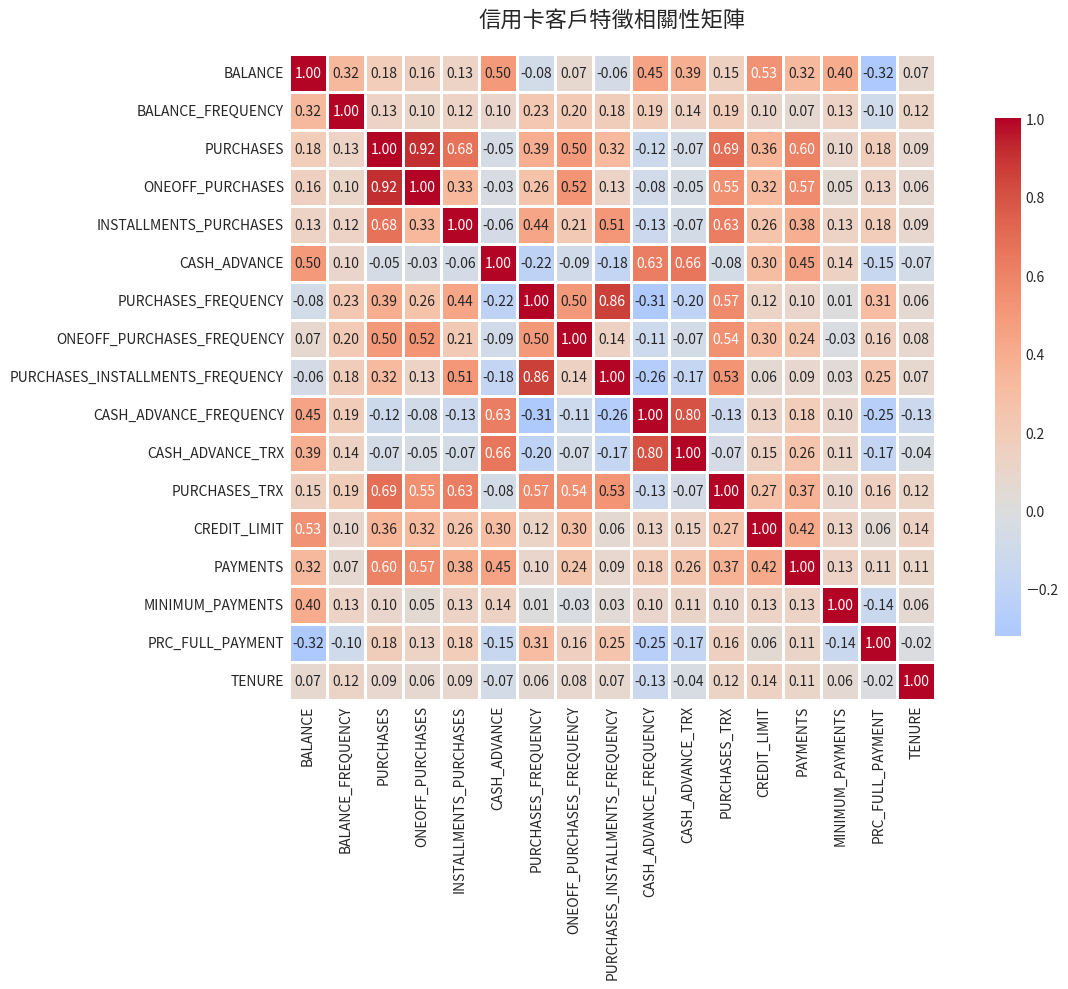

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('信用卡客戶特徵相關性矩陣', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
print("💡 高度相關的特徵對：")
# 找出高度相關的特徵對 (相關係數 > 0.7)
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((correlation_matrix.columns[i],
                            correlation_matrix.columns[j],
                            correlation_matrix.iloc[i, j]))

for pair in high_corr[:5]:  # 顯示前5組
    print(f"  - {pair[0]} vs {pair[1]}: {pair[2]:.3f}")

💡 高度相關的特徵對：
  - PURCHASES vs ONEOFF_PURCHASES: 0.917
  - PURCHASES_FREQUENCY vs PURCHASES_INSTALLMENTS_FREQUENCY: 0.863
  - CASH_ADVANCE_FREQUENCY vs CASH_ADVANCE_TRX: 0.800


### 1.4 特徵標準化

> **為什麼需要標準化？**

在聚類分析中，**距離計算**是核心。如果特徵的尺度差異很大（例如信用額度可能是數十萬，而購買頻率只有 0-1），那麼數值大的特徵會主導距離計算，導致聚類結果偏差。

**標準化 (Standardization)** 將所有特徵轉換為均值為 0、標準差為 1 的分布，確保每個特徵的貢獻度相等。

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
sf_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [ ]:
sf_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960378,-0.528979,-0.302400,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688678,0.818642,0.097500,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826100,-0.383805,-0.093293,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826100,-0.598688,-0.228307,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905410,-0.364368,-0.257266,-0.525551,0.36068


In [ ]:
print("--- 標準化前後對比 ---")
print("\n原始資料統計：")
print(df.describe().loc[['mean', 'std']].round(2))

print("\n標準化後統計：")
print(sf_scaled.describe().loc[['mean', 'std']].round(2))

print("\n✅ 特徵標準化完成！所有特徵現在具有相同的尺度。")

--- 標準化前後對比 ---

原始資料統計：
      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
mean  1564.47               0.88    1003.20            592.44   
std   2081.53               0.24    2136.63           1659.89   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
mean                  411.07        978.87                 0.49   
std                   904.34       2097.16                 0.40   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
mean                         0.2                              0.36   
std                          0.3                              0.40   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
mean                    0.14              3.25          14.71       4494.28   
std                     0.20              6.82          24.86       3638.65   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
mean   1733.14            844.91              0.15   11.52  
std   

## 🎯 Part 2: K-means 分群分析

K-means 是最經典、最常用的聚類演算法。核心概念是「**物以類聚**」：將資料點分配到最近的群組中心，並不斷更新中心位置，直到收斂。

**演算法步驟回顧：**
1. 隨機初始化 K 個群組中心點 (centroids)
2. 將每個資料點分配給最近的中心點
3. 重新計算每個群組的中心點（取平均）
4. 重複步驟 2-3，直到中心點不再變動（收斂）

**關鍵問題：如何選擇 K 值？**

In [ ]:
# 計算不同 K 值的群內平方和 (WCSS - Within-Cluster Sum of Squares)
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

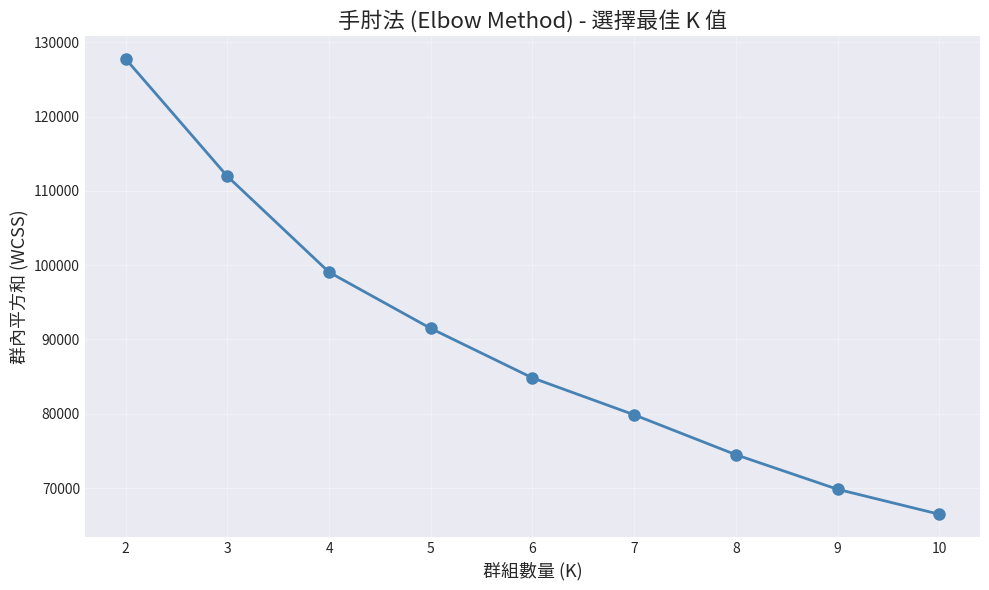

💡 解讀：
   - 觀察曲線的「手肘點」（明顯轉折處）


In [ ]:
# 繪製手肘圖
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.title('手肘法 (Elbow Method) - 選擇最佳 K 值', fontsize=16, fontweight='bold')
plt.xlabel('群組數量 (K)', fontsize=13)
plt.ylabel('群內平方和 (WCSS)', fontsize=13)
plt.xticks(k_range)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 解讀：")
print("   - 觀察曲線的「手肘點」（明顯轉折處）")

In [ ]:
# 輪廓係數 (Silhouette Score) - 驗證最佳 K 值
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

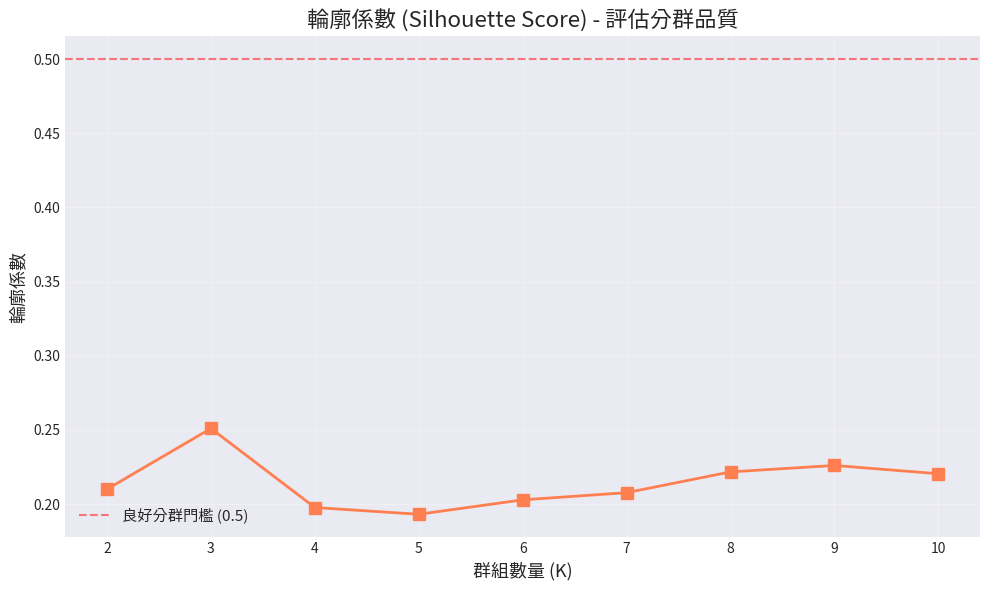


✅ 輪廓係數最高的 K 值: 3
   對應的輪廓係數: 0.251

💡 輪廓係數範圍 [-1, 1]:
   - 接近 1：分群非常好
   - 接近 0：資料點在群組邊界上
   - 接近 -1：分群錯誤


In [ ]:
# 繪製輪廓係數圖
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
plt.title('輪廓係數 (Silhouette Score) - 評估分群品質', fontsize=16, fontweight='bold')
plt.xlabel('群組數量 (K)', fontsize=13)
plt.ylabel('輪廓係數', fontsize=13)
plt.xticks(k_range)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='良好分群門檻 (0.5)')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 找出最佳 K 值
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ 輪廓係數最高的 K 值: {best_k}")
print(f"   對應的輪廓係數: {max(silhouette_scores):.3f}")
print("\n💡 輪廓係數範圍 [-1, 1]:")
print("   - 接近 1：分群非常好")
print("   - 接近 0：資料點在群組邊界上")
print("   - 接近 -1：分群錯誤")

In [ ]:
optimal_k = 4 # 根據手肘法和輪廓係數的結果

kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(df_scaled)

# 將分群結果加回原始資料
df['Cluster'] = cluster_labels

In [ ]:
print(f"--- K-means 分群完成 (K={optimal_k}) ---")
print("\n各群組的客戶數量：")
print(df['Cluster'].value_counts().sort_index())

print("\n各群組佔比：")
print((df['Cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

--- K-means 分群完成 (K=4) ---

各群組的客戶數量：
Cluster
0    3977
1     409
2    1197
3    3367
Name: count, dtype: int64

各群組佔比：
Cluster
0    44.44
1     4.57
2    13.37
3    37.62
Name: proportion, dtype: float64


In [ ]:
# 為了視覺化高維資料，我們先用 PCA 降到 2 維
pca = PCA(n_components=2 , random_state=42)
principal_components = pca.fit_transform(df_scaled)

# 建立 PCA DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

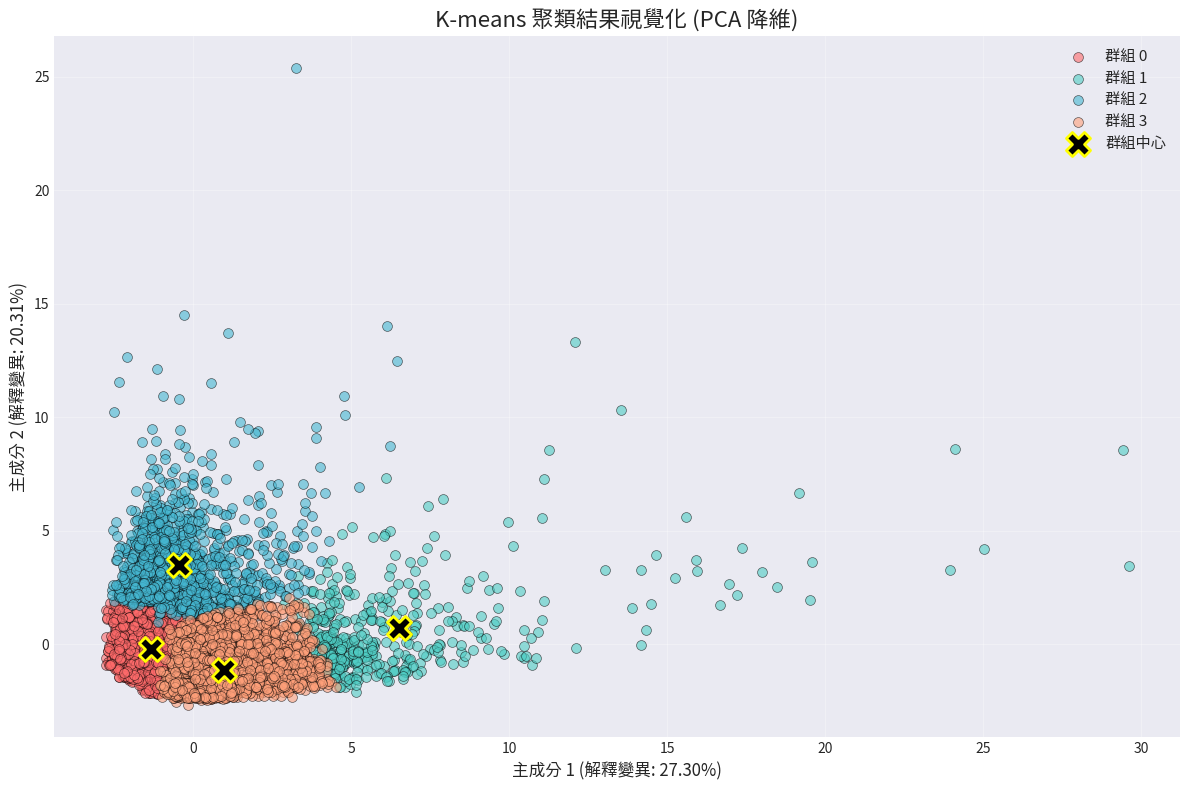

✅ PCA 降維完成！前兩個主成分解釋了 47.61% 的總變異


In [ ]:
# 繪製散佈圖
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for i in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'],
                c=colors[i], label=f'群組 {i}',
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# 繪製群組中心點
centers_pca = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c='black', marker='X', s=300,
            edgecolors='yellow', linewidth=2,
            label='群組中心', zorder=5)

plt.title('K-means 聚類結果視覺化 (PCA 降維)', fontsize=16, fontweight='bold')
plt.xlabel(f'主成分 1 (解釋變異: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'主成分 2 (解釋變異: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ PCA 降維完成！前兩個主成分解釋了 {sum(pca.explained_variance_ratio_):.2%} 的總變異")

In [ ]:
# 分析各群組的特徵平均值
# 選擇關鍵特徵進行比較
key_features_analysis = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT',
                         'PAYMENTS', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE']

# 計算各群組的平均值
cluster_profile = df.groupby('Cluster')[key_features_analysis].mean()

print("--- 各群組的特徵輪廓 (平均值) ---")
print(cluster_profile.round(2))

--- 各群組的特徵輪廓 (平均值) ---
         BALANCE  PURCHASES  CREDIT_LIMIT  PAYMENTS  PURCHASES_FREQUENCY  \
Cluster                                                                    
0        1012.66     270.04       3278.64    974.26                 0.17   
1        3551.15    7681.62       9696.94   7288.74                 0.95   
2        4602.45     501.86       7546.16   3484.05                 0.29   
3         894.91    1236.18       4213.21   1332.19                 0.89   

         CASH_ADVANCE  
Cluster                
0              596.51  
1              653.64  
2             4521.51  
3              210.57  


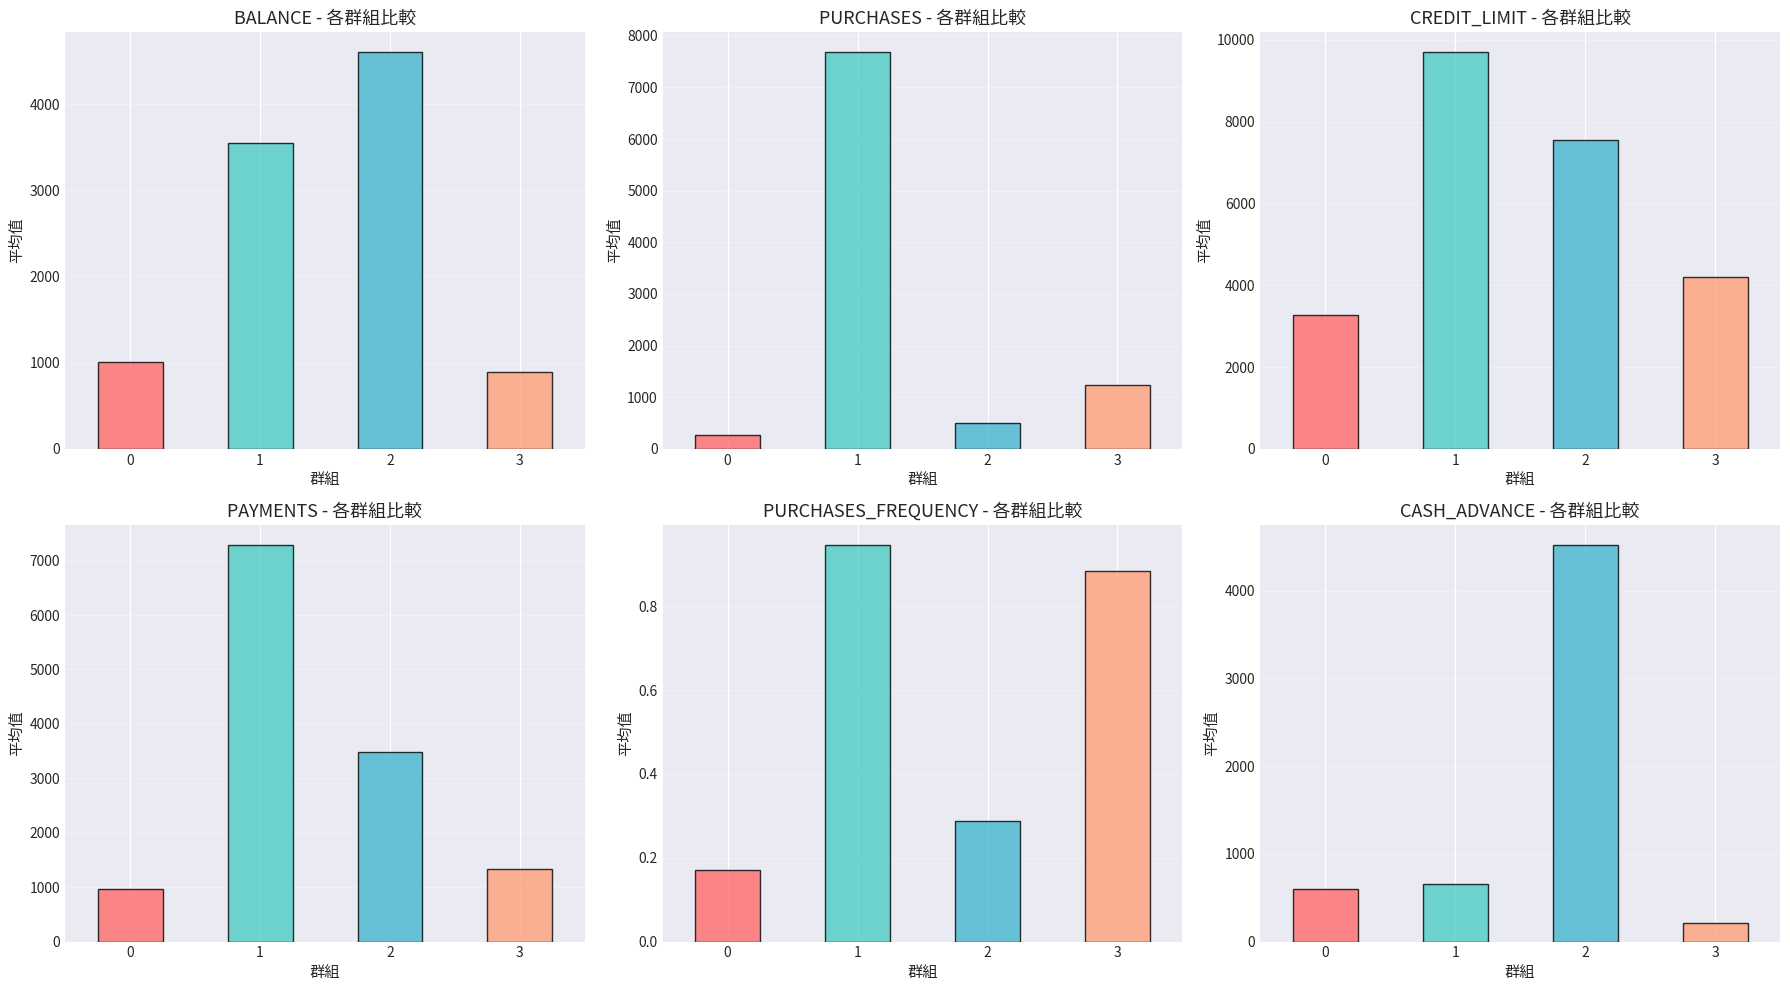

In [ ]:
# 視覺化群組輪廓
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features_analysis):
    cluster_profile[feature].plot(kind='bar', ax=axes[idx],
                                   color=colors[:optimal_k], alpha=0.8, edgecolor='black')
    axes[idx].set_title(f'{feature} - 各群組比較', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('群組', fontsize=11)
    axes[idx].set_ylabel('平均值', fontsize=11)
    axes[idx].grid(alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### 2.6 商業洞察：客戶分群解讀

根據各群組的特徵輪廓，我們可以為每個群組貼上「商業標籤」，並制定相應的行銷策略。

In [ ]:
cluster_names = {
    0: "謹慎使用者",
    1: "高端消費客戶",
    2: "循環利息客戶",
    3: "潛力開發客戶"
}

cluster_strategies = {
    0: "低消費、低信用額度使用率 → 推廣小額分期、現金回饋",
    1: "高消費、高信用額度 → VIP 服務、機場貴賓室、高端卡升級",
    2: "高預借現金、低還款 → 債務整合方案、理財諮詢",
    3: "中等消費潛力 → 消費回饋活動、提高信用額度"
}

In [ ]:
print("="*80)
print("🎯 客戶分群商業洞察與行銷策略")
print("="*80)

for cluster_id in range(optimal_k):
    print(f"\n【群組 {cluster_id}】: {cluster_names.get(cluster_id, f'群組{cluster_id}')}")
    print(f"  客戶數量: {df[df['Cluster']==cluster_id].shape[0]} 人 ({df[df['Cluster']==cluster_id].shape[0]/len(df)*100:.1f}%)")
    print(f"  行銷策略: {cluster_strategies.get(cluster_id, '待分析')}")
    print("-"*80)

print("\n✅ 分群分析完成！銀行可根據不同群組制定差異化服務策略")

🎯 客戶分群商業洞察與行銷策略

【群組 0】: 謹慎使用者
  客戶數量: 3977 人 (44.4%)
  行銷策略: 低消費、低信用額度使用率 → 推廣小額分期、現金回饋
--------------------------------------------------------------------------------

【群組 1】: 高端消費客戶
  客戶數量: 409 人 (4.6%)
  行銷策略: 高消費、高信用額度 → VIP 服務、機場貴賓室、高端卡升級
--------------------------------------------------------------------------------

【群組 2】: 循環利息客戶
  客戶數量: 1197 人 (13.4%)
  行銷策略: 高預借現金、低還款 → 債務整合方案、理財諮詢
--------------------------------------------------------------------------------

【群組 3】: 潛力開發客戶
  客戶數量: 3367 人 (37.6%)
  行銷策略: 中等消費潛力 → 消費回饋活動、提高信用額度
--------------------------------------------------------------------------------

✅ 分群分析完成！銀行可根據不同群組制定差異化服務策略


## 🌲 Part 3: 階層式分群法 (Hierarchical Clustering)

K-means 的缺點是需要事先指定 K 值。**階層式分群法**則不需要預先決定群組數量，而是建立一個完整的階層樹狀結構，讓我們可以在不同層級上觀察資料的分群情況。

**凝聚式階層分群法 (Agglomerative) 步驟：**
1. 每個資料點自成一群
2. 找出最相似的兩個群組並合併
3. 重複步驟 2，直到所有點合併成一個大群
4. 透過「切割樹狀圖」來決定最終的群組數量

**優勢：**
- 不需預設 K 值
- 提供完整的階層關係
- 適合探索性分析

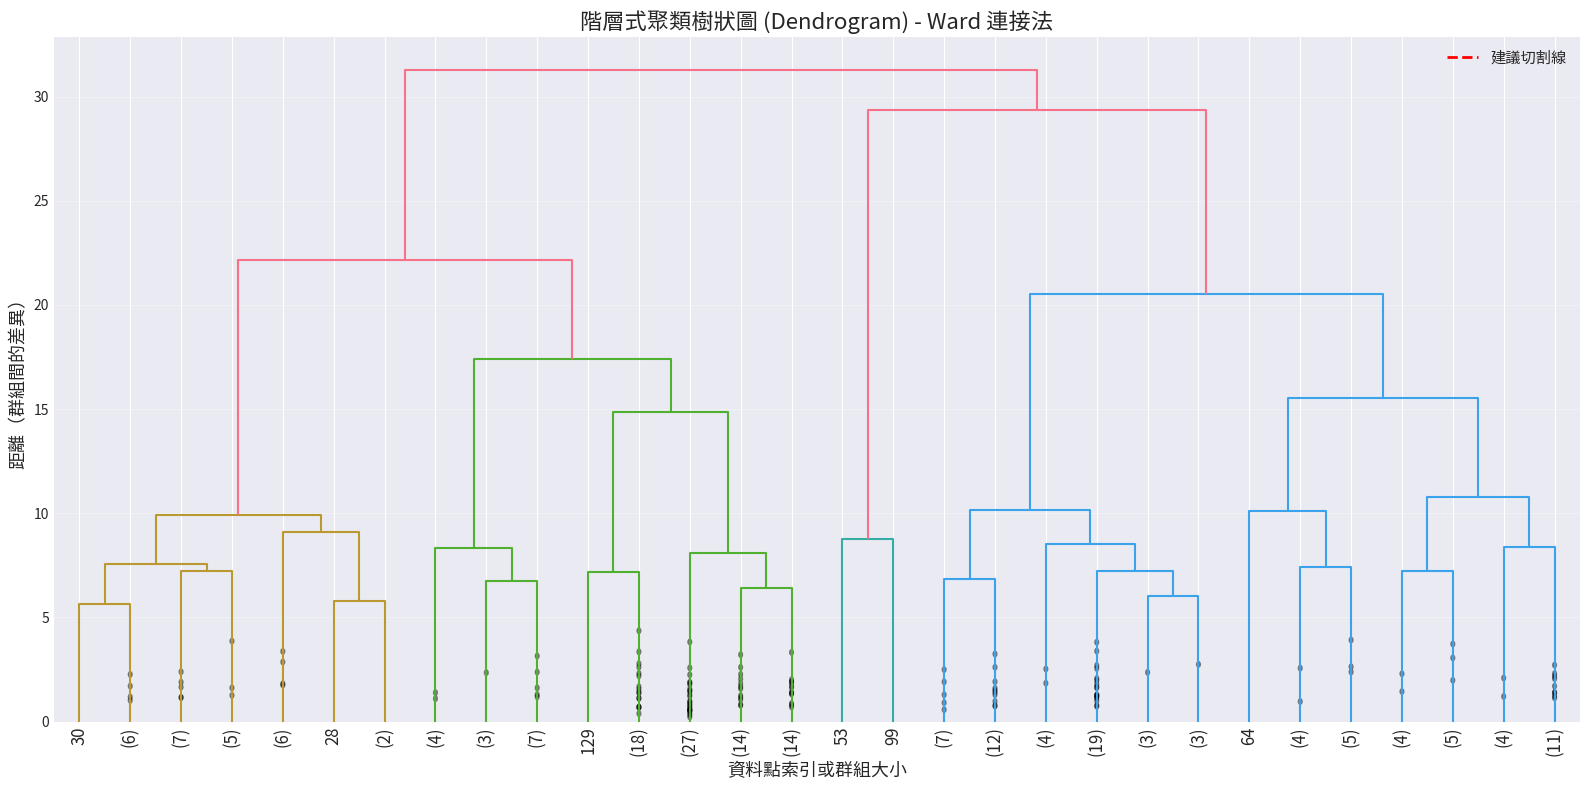

In [ ]:
# [程式碼區塊 3.1：建立階層式聚類並繪製樹狀圖 (Dendrogram)]
# 為了視覺化清晰，我們抽取部分資料（200 筆）
sample_size = 200
df_sample = sf_scaled.sample(n=sample_size, random_state=42)

# 使用 Ward 方法計算連接矩陣
linkage_matrix = linkage(df_sample, method='ward')

# 繪製樹狀圖
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, show_leaf_counts=True, leaf_rotation=90, leaf_font_size=12, show_contracted=True)

plt.title('階層式聚類樹狀圖 (Dendrogram) - Ward 連接法', fontsize=16, fontweight='bold')
plt.xlabel('資料點索引或群組大小', fontsize=13)
plt.ylabel('距離（群組間的差異）', fontsize=13)
plt.axhline(y=50, color='red', linestyle='--', linewidth=2, label='建議切割線')
plt.legend(fontsize=11)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# 執行階層式聚類
n_clusters_hierarchical = 4 # 從樹狀圖中觀察到的合適群組數量，或根據 K-means 結果選擇

hierarchical_model = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(df_scaled)
# 計算輪廓係數
hierarchical_silhouette = silhouette_score(df_scaled, hierarchical_labels)

In [ ]:
print(f"--- 階層式聚類完成 (群組數={n_clusters_hierarchical}) ---")
print(f"輪廓係數: {hierarchical_silhouette:.3f}")
print("\n各群組的客戶數量：")
print(pd.Series(hierarchical_labels).value_counts().sort_index())

# 與 K-means 結果比較
comparison_df = pd.DataFrame({
    'K-means': cluster_labels,
    'Hierarchical': hierarchical_labels
})

print("\n--- K-means vs 階層式聚類比較 ---")
print(pd.crosstab(comparison_df['K-means'], comparison_df['Hierarchical'],
                  rownames=['K-means'], colnames=['Hierarchical']))

--- 階層式聚類完成 (群組數=4) ---
輪廓係數: 0.160

各群組的客戶數量：
0    4875
1     300
2    1194
3    2581
Name: count, dtype: int64

--- K-means vs 階層式聚類比較 ---
Hierarchical     0    1    2     3
K-means                           
0             3667    0  277    33
1                7  263    6   133
2              181    4  863   149
3             1020   33   48  2266


## 🔍 Part 4: DBSCAN 密度分群法與異常檢測


**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** 是一種基於密度的聚類演算法，與 K-means 和階層式聚類最大的不同是：

**核心優勢：**
1. **不需指定 K 值**：自動發現群組數量
2. **可發現任意形狀的群組**：不限於球形
3. **自動識別離群點 (Outliers)**：標記為噪音點

**關鍵參數：**
- `eps` (ε)：鄰域半徑，定義「密集」的範圍
- `min_samples`：成為核心點所需的最小鄰居數量

**應用場景：異常交易檢測**
在金融領域，DBSCAN 特別適合用於檢測**異常交易**。正常交易會形成密集群組，而異常交易（如信用卡盜刷、洗錢）則會被標記為噪音點。

In [ ]:
# DBSCAN 密度分群法
# 設定參數
eps_value = 2.5  # 鄰域半徑，需要根據資料特性調整
min_samples_value = 10   # 成為核心點所需的最小鄰居數量

dbscan_model = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan_labels = dbscan_model.fit_predict(df_scaled)

In [ ]:
# 統計結果
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"--- DBSCAN 聚類完成 ---")
print(f"發現的群組數量: {n_clusters_dbscan}")
print(f"離群點（噪音）數量: {n_noise} ({n_noise/len(df)*100:.2f}%)")
print("\n各群組的客戶數量：")
unique, counts = np.unique(dbscan_labels, return_counts=True)
for label, count in zip(unique, counts):
    if label == -1:
        print(f"  噪音點: {count}")
    else:
        print(f"  群組 {label}: {count}")

--- DBSCAN 聚類完成 ---
發現的群組數量: 1
離群點（噪音）數量: 386 (4.31%)

各群組的客戶數量：
  噪音點: 386
  群組 0: 8564


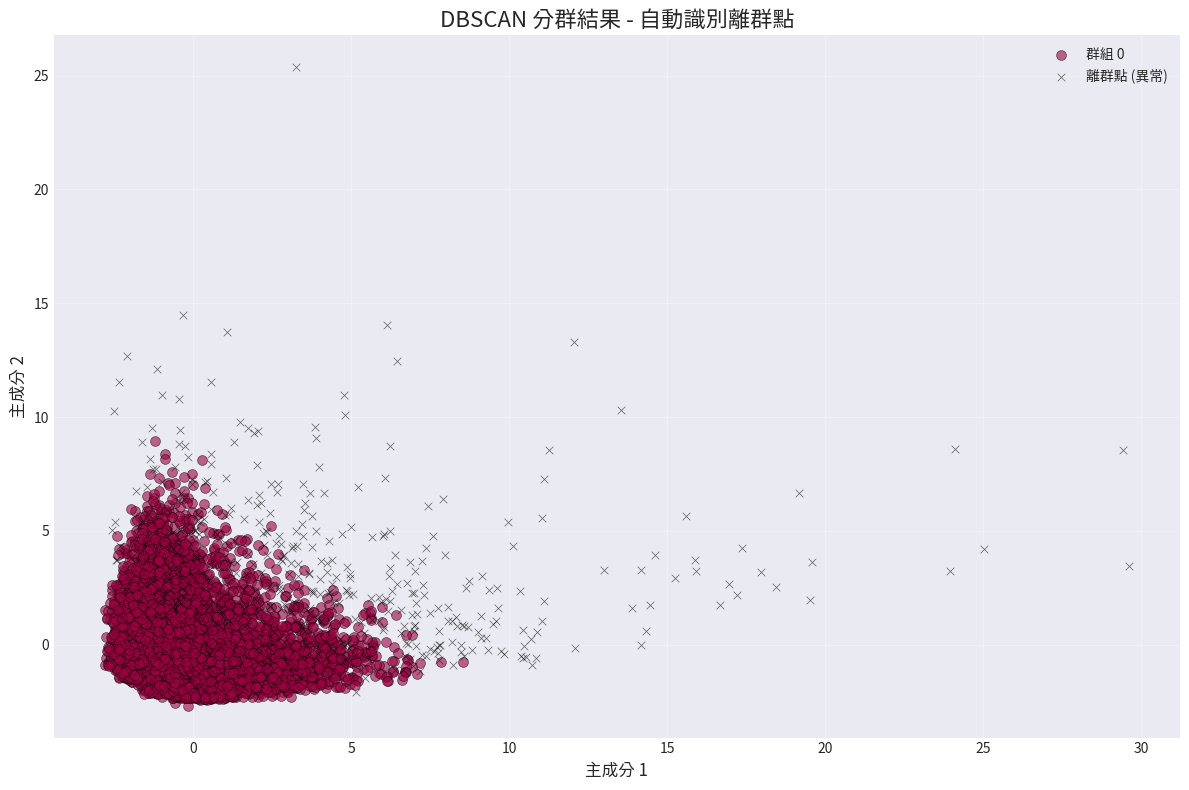


✅ DBSCAN 成功識別出 386 個潛在的異常客戶！
💡 這些異常客戶可能需要進一步調查（如：交易模式異常、信用風險）


In [ ]:
# 視覺化 DBSCAN 結果
# 使用 PCA 降維
pca_dbscan = PCA(n_components=2, random_state=42)
components_dbscan = pca_dbscan.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))

# 繪製各群組
unique_labels = set(dbscan_labels)
colors_dbscan = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors_dbscan):
    if label == -1:
        # 噪音點用黑色標記
        color = 'black'
        marker = 'x'
        size = 30
        label_name = '離群點 (異常)'
    else:
        marker = 'o'
        size = 50
        label_name = f'群組 {label}'

    mask = (dbscan_labels == label)
    plt.scatter(components_dbscan[mask, 0], components_dbscan[mask, 1],
                c=[color], marker=marker, s=size, alpha=0.6,
                edgecolors='black', linewidth=0.5, label=label_name)

plt.title('DBSCAN 分群結果 - 自動識別離群點', fontsize=16, fontweight='bold')
plt.xlabel(f'主成分 1', fontsize=12)
plt.ylabel(f'主成分 2', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ DBSCAN 成功識別出 {n_noise} 個潛在的異常客戶！")
print("💡 這些異常客戶可能需要進一步調查（如：交易模式異常、信用風險）")

In [ ]:
# 分析離群點特徵
# 將 DBSCAN 標籤加入資料
df['DBSCAN_Cluster'] = dbscan_labels

# 比較正常客戶 vs 離群客戶
outliers_df = df[df['DBSCAN_Cluster'] == -1]
normal_df = df[df['DBSCAN_Cluster'] != -1]

comparison_features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT',
                       'CASH_ADVANCE', 'PAYMENTS']

print("--- 正常客戶 vs 離群客戶特徵比較 ---\n")
for feature in comparison_features:
    if feature in df.columns:
        normal_mean = normal_df[feature].mean()
        outlier_mean = outliers_df[feature].mean()
        outlier_mean = outliers_df[feature].mean()
        diff_pct = ((outlier_mean - normal_mean) / normal_mean * 100) if normal_mean != 0 else 0

        print(f"{feature}:")
        print(f"  正常客戶平均: {normal_mean:,.2f}")
        print(f"  離群客戶平均: {outlier_mean:,.2f}")
        print(f"  差異百分比: {diff_pct:+.1f}%\n")

--- 正常客戶 vs 離群客戶特徵比較 ---

BALANCE:
  正常客戶平均: 1,420.52
  離群客戶平均: 4,758.26
  差異百分比: +235.0%

PURCHASES:
  正常客戶平均: 786.44
  離群客戶平均: 5,812.41
  差異百分比: +639.1%

CREDIT_LIMIT:
  正常客戶平均: 4,242.90
  離群客戶平均: 10,071.68
  差異百分比: +137.4%

CASH_ADVANCE:
  正常客戶平均: 835.48
  離群客戶平均: 4,160.31
  差異百分比: +398.0%

PAYMENTS:
  正常客戶平均: 1,379.89
  離群客戶平均: 9,570.57
  差異百分比: +593.6%



## 📉 Part 5: 降維技術 - PCA (主成分分析)

**為什麼需要降維？**

在真實世界的資料集中，特徵數量可能高達數百甚至數千個（例如：圖像有數萬個像素）。這會帶來「**維度詛咒 (Curse of Dimensionality)**」：
- 計算成本暴增
- 視覺化困難（人類只能看 2-3 維）
- 模型容易過擬合
- 距離度量失去意義

**PCA (Principal Component Analysis) 主成分分析**

PCA 是最經典的**線性降維**方法，核心思想是：
1. 找出資料變異最大的方向（主成分）
2. 將高維資料投影到這些主成分上
3. 保留最重要的幾個主成分，丟棄其他

**應用：**
- 資料視覺化（降到 2D/3D）
- 去除雜訊
- 特徵提取
- 加速模型訓練

In [ ]:
# 執行 PCA 並分析解釋變異
pca_full = PCA(random_state=42)
pca_full.fit(df_scaled)


# 計算累積解釋變異比例
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

In [ ]:
print(f"--- PCA 分析結果 ---")
print(f"原始特徵數量: {df_scaled.shape[1]}")
print(f"\n前 10 個主成分的解釋變異比例:")
for i in range(min(10, len(explained_variance_ratio))):
    print(f"  PC{i+1}: {explained_variance_ratio[i]:.4f} (累積: {cumulative_variance_ratio[i]:.4f})")

# 找出能解釋 90% 變異所需的主成分數量
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"\n✅ 需要 {n_components_90} 個主成分才能解釋 90% 的變異")

--- PCA 分析結果 ---
原始特徵數量: 17

前 10 個主成分的解釋變異比例:
  PC1: 0.2730 (累積: 0.2730)
  PC2: 0.2031 (累積: 0.4761)
  PC3: 0.0881 (累積: 0.5642)
  PC4: 0.0748 (累積: 0.6390)
  PC5: 0.0622 (累積: 0.7013)
  PC6: 0.0574 (累積: 0.7587)
  PC7: 0.0488 (累積: 0.8075)
  PC8: 0.0430 (累積: 0.8505)
  PC9: 0.0380 (累積: 0.8885)
  PC10: 0.0308 (累積: 0.9193)

✅ 需要 10 個主成分才能解釋 90% 的變異


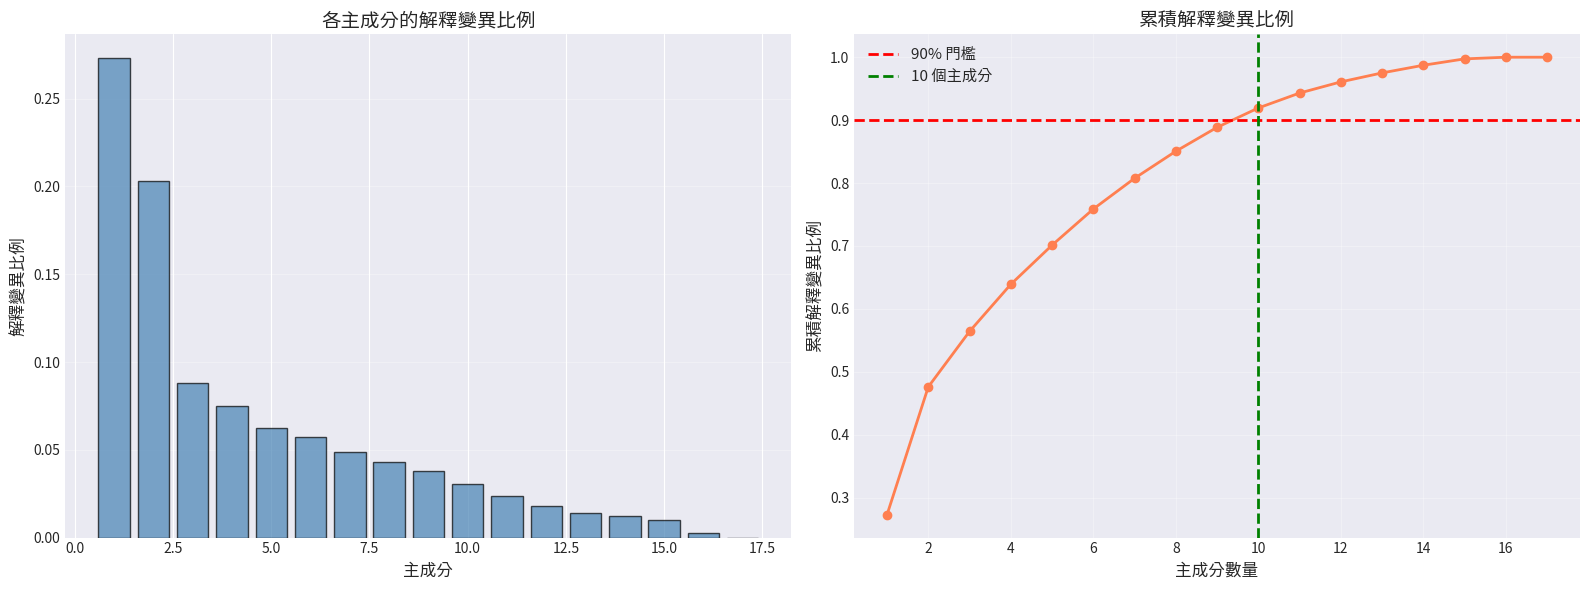

In [ ]:
# 視覺化主成分解釋變異
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：各主成分的解釋變異比例
axes[0].bar(range(1, len(explained_variance_ratio)+1),
            explained_variance_ratio,
            alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_title('各主成分的解釋變異比例', fontsize=14, fontweight='bold')
axes[0].set_xlabel('主成分', fontsize=12)
axes[0].set_ylabel('解釋變異比例', fontsize=12)
axes[0].grid(alpha=0.3, axis='y')

# 右圖：累積解釋變異比例
axes[1].plot(range(1, len(cumulative_variance_ratio)+1),
             cumulative_variance_ratio,
             marker='o', linewidth=2, markersize=6, color='coral')
axes[1].axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90% 門檻')
axes[1].axvline(x=n_components_90, color='green', linestyle='--', linewidth=2,
                label=f'{n_components_90} 個主成分')
axes[1].set_title('累積解釋變異比例', fontsize=14, fontweight='bold')
axes[1].set_xlabel('主成分數量', fontsize=12)
axes[1].set_ylabel('累積解釋變異比例', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

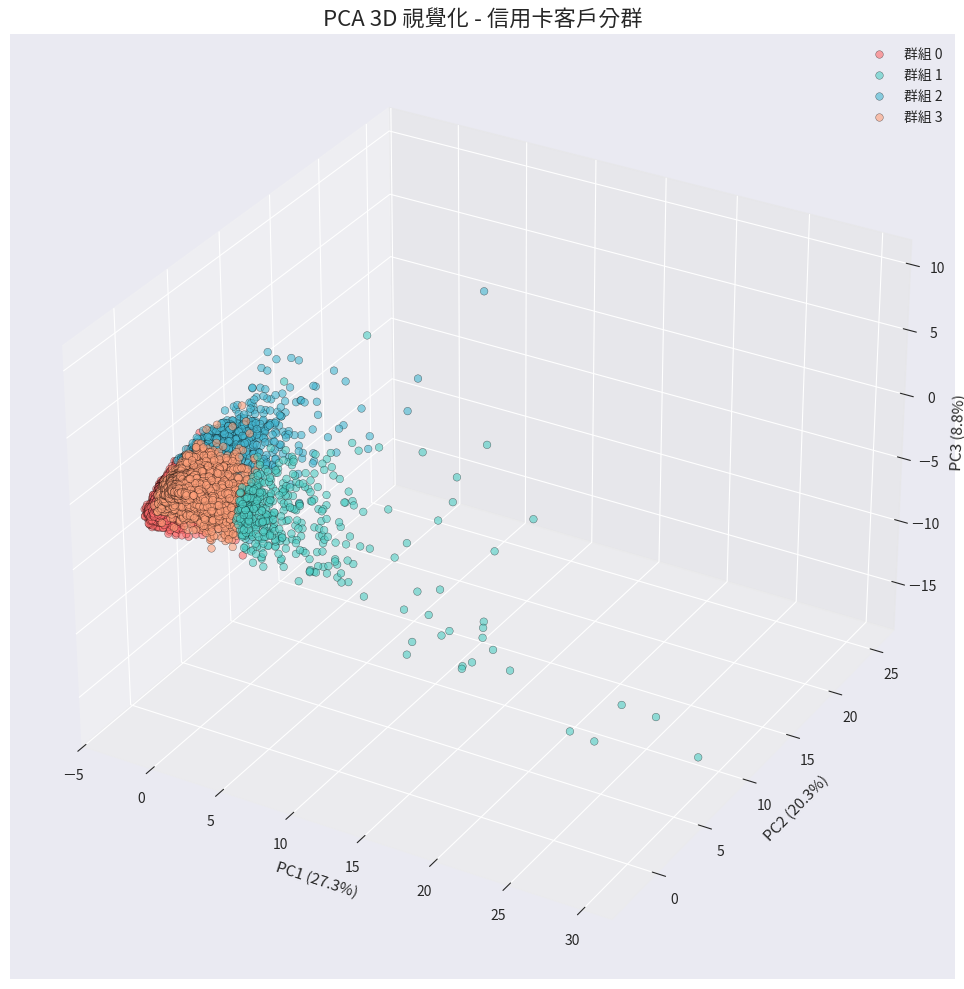

✅ 前 3 個主成分解釋了 56.42% 的總變異


In [ ]:
# 使用 PCA 進行 3D 視覺化
from mpl_toolkits.mplot3d import Axes3D

# 降到 3 維
pca_3d = PCA(n_components=3, random_state=42)
components_3d = pca_3d.fit_transform(df_scaled)

# 使用原本的 K-means 分群結果上色
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(optimal_k):
    mask = (cluster_labels == i)
    ax.scatter(components_3d[mask, 0],
               components_3d[mask, 1],
               components_3d[mask, 2],
               c=colors[i], label=f'群組 {i}',
               alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

ax.set_title('PCA 3D 視覺化 - 信用卡客戶分群', fontsize=16, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=11)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"✅ 前 3 個主成分解釋了 {sum(pca_3d.explained_variance_ratio_):.2%} 的總變異")

## 🎨 Part 6: t-SNE 非線性降維

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** 是一種**非線性降維**技術，特別擅長將高維資料視覺化到 2D 或 3D。

**與 PCA 的差異：**
| 特性 | PCA | t-SNE |
|------|-----|-------|
| 類型 | 線性降維 | 非線性降維 |
| 保留資訊 | 全局結構、變異 | 局部結構、相似性 |
| 速度 | 快速 | 較慢 |
| 可解釋性 | 高（主成分有意義） | 低（純視覺化） |
| 最佳用途 | 特徵提取、預處理 | 視覺化探索 |

**優勢：**
- 能夠呈現複雜的非線性結構
- 視覺化效果優秀，群組分離明顯

**注意：**
t-SNE 主要用於**視覺化**，不建議用於特徵提取或後續建模。

In [ ]:
# [程式碼區塊 6.1：使用 t-SNE 進行非線性降維]
print("⏳ 執行 t-SNE 中... (這可能需要一些時間)")

tsne = TSNE(n_components=2, random_state=42, perplexity=30 , n_iter=1000, verbose= 0)
tsne_components = tsne.fit_transform(df_scaled)

print("✅ t-SNE 降維完成！")



⏳ 執行 t-SNE 中... (這可能需要一些時間)
✅ t-SNE 降維完成！


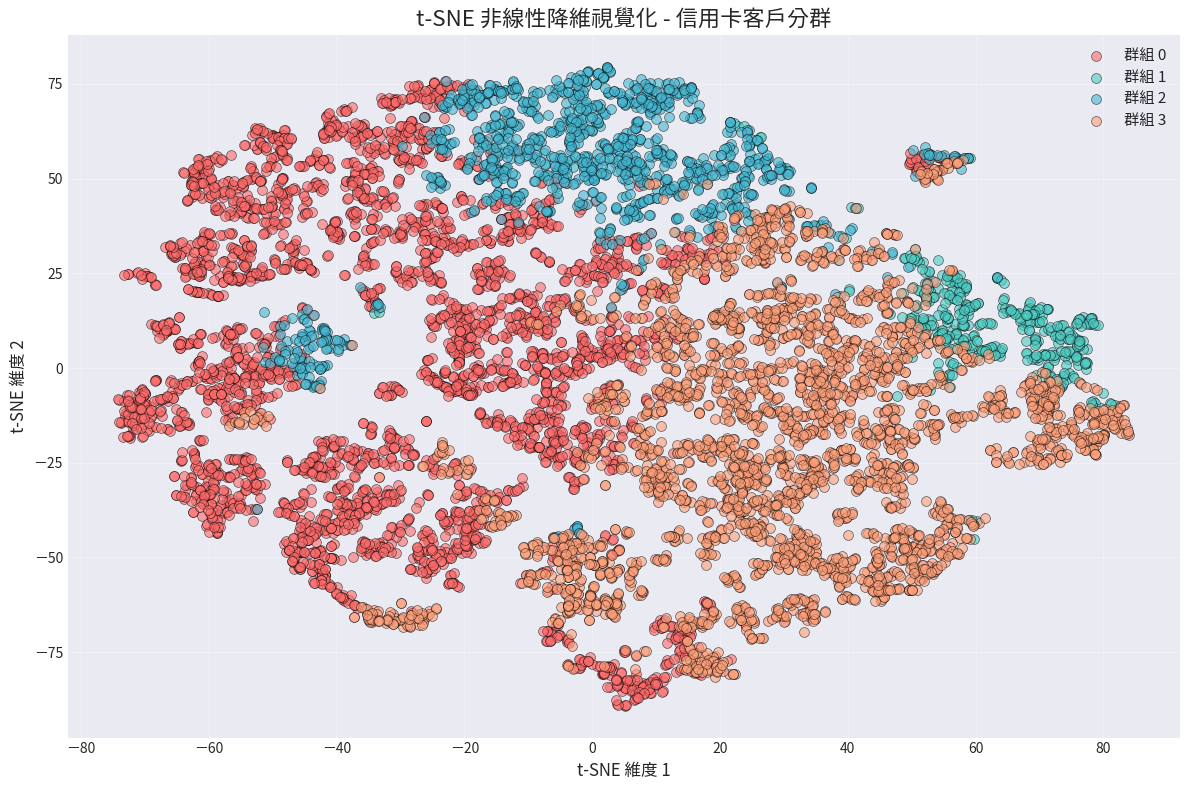


💡 觀察：t-SNE 通常能更清楚地分離群組，展現資料的局部結構


In [ ]:
# 繪製 t-SNE 結果
plt.figure(figsize=(12, 8))

for i in range(optimal_k):
    mask = (cluster_labels == i)
    plt.scatter(tsne_components[mask, 0],
                tsne_components[mask, 1],
                c=colors[i], label=f'群組 {i}',
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.title('t-SNE 非線性降維視覺化 - 信用卡客戶分群', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE 維度 1', fontsize=12)
plt.ylabel('t-SNE 維度 2', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 觀察：t-SNE 通常能更清楚地分離群組，展現資料的局部結構")

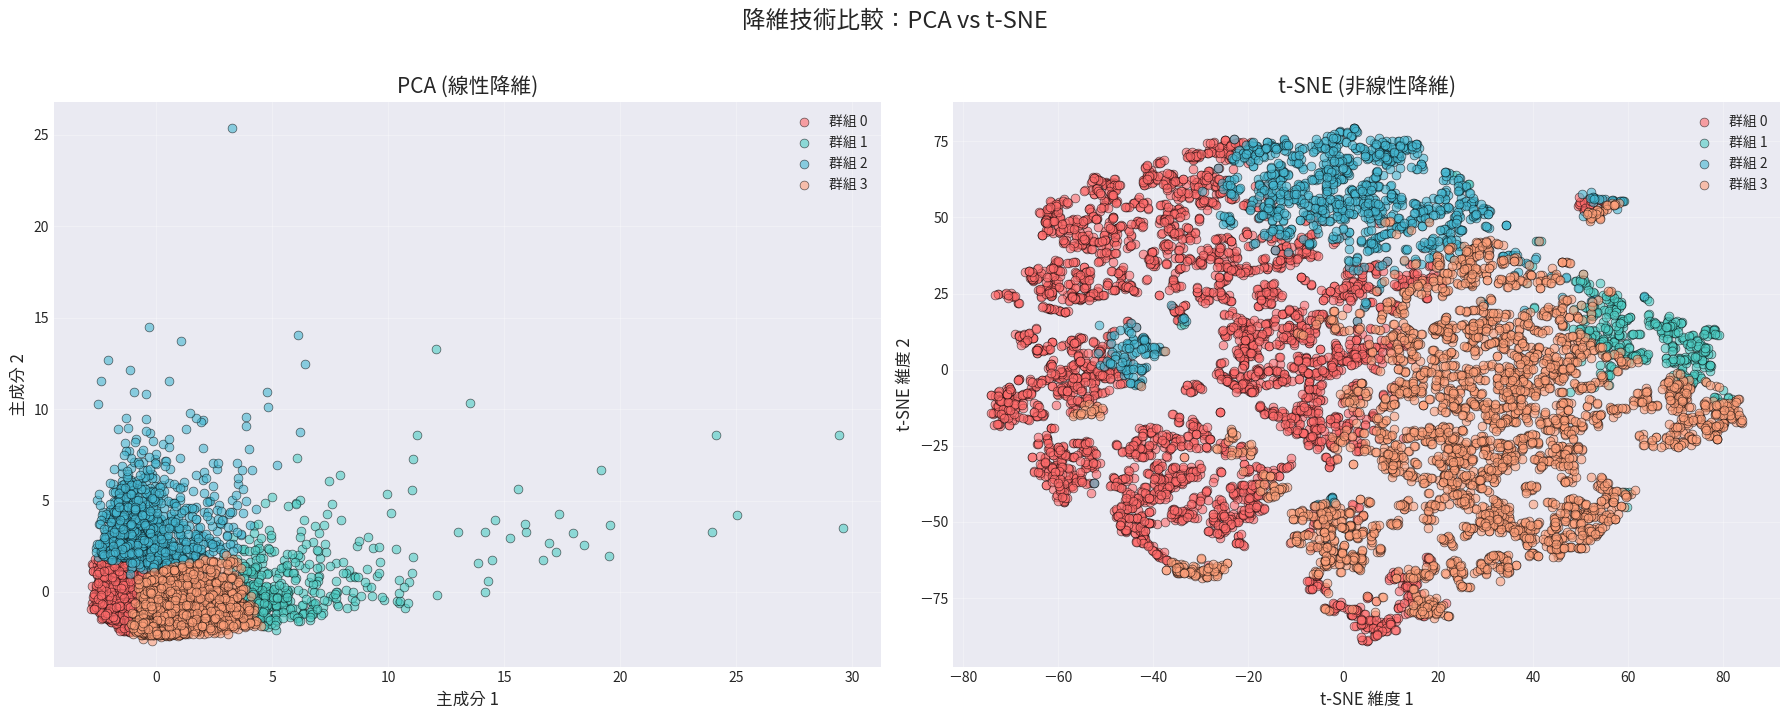

✅ 比較完成！可以看到 t-SNE 在視覺化上通常能更好地分離群組


In [ ]:
# PCA vs t-SNE 視覺化比較
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA
for i in range(optimal_k):
    mask = (cluster_labels == i)
    axes[0].scatter(principal_components[mask, 0],
                    principal_components[mask, 1],
                    c=colors[i], label=f'群組 {i}',
                    alpha=0.6, s=40, edgecolors='black', linewidth=0.5)

axes[0].set_title('PCA (線性降維)', fontsize=15, fontweight='bold')
axes[0].set_xlabel('主成分 1', fontsize=12)
axes[0].set_ylabel('主成分 2', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# t-SNE
for i in range(optimal_k):
    mask = (cluster_labels == i)
    axes[1].scatter(tsne_components[mask, 0],
                    tsne_components[mask, 1],
                    c=colors[i], label=f'群組 {i}',
                    alpha=0.6, s=40, edgecolors='black', linewidth=0.5)

axes[1].set_title('t-SNE (非線性降維)', fontsize=15, fontweight='bold')
axes[1].set_xlabel('t-SNE 維度 1', fontsize=12)
axes[1].set_ylabel('t-SNE 維度 2', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.suptitle('降維技術比較：PCA vs t-SNE', fontsize=17, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✅ 比較完成！可以看到 t-SNE 在視覺化上通常能更好地分離群組")

## 🎯 Part 7: 綜合案例 - 完整的客戶分群專案流程

讓我們整合所有學到的技術，完成一個完整的客戶分群專案。

**專案目標：**
為銀行設計一套客戶分群系統，並提供具體的行銷建議

**完整流程：**
1. ✅ 資料探索與預處理
2. ✅ 使用多種聚類演算法
3. ✅ 評估與選擇最佳模型
4. ✅ 視覺化與商業解讀
5. 🆕 建立客戶輪廓報告
6. 🆕 提出行動方案

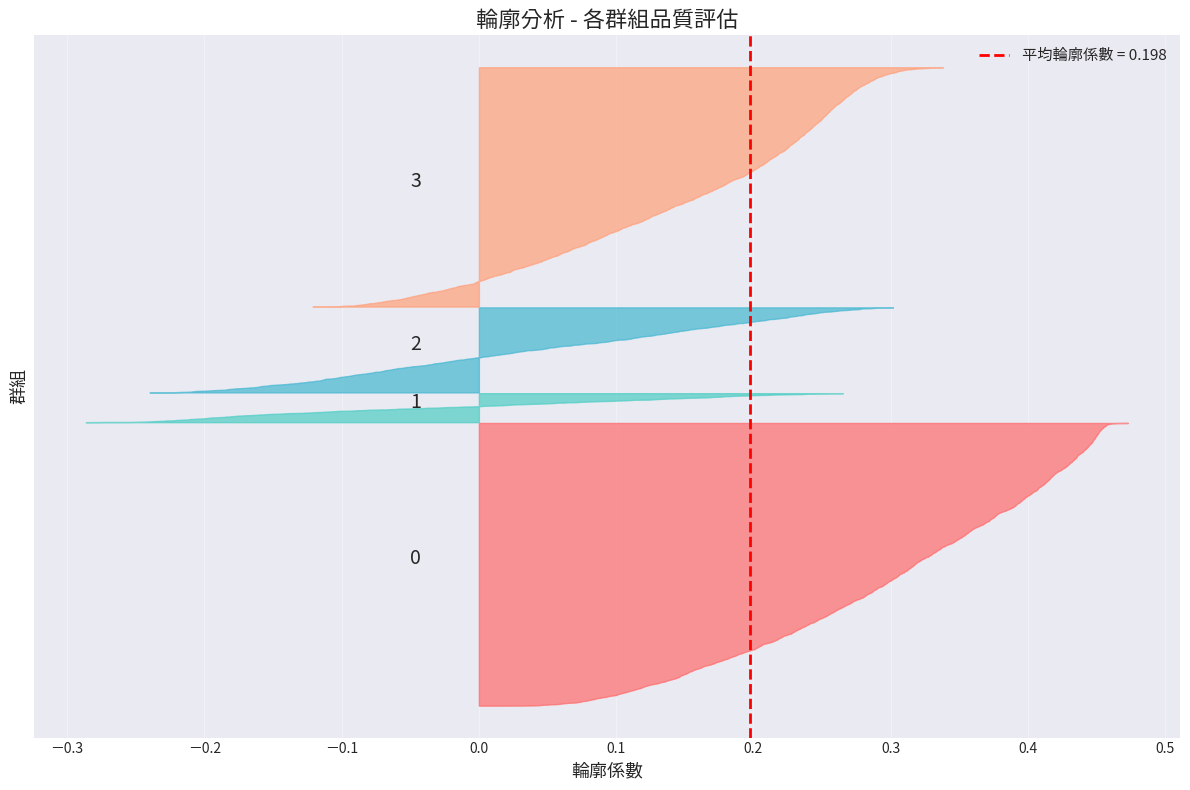

📊 整體輪廓係數: 0.198

各群組輪廓係數:
  群組 0: 0.305
  群組 1: -0.025
  群組 2: 0.043
  群組 3: 0.153


In [ ]:
# 輪廓分析 - 詳細評估各群組品質
from sklearn.metrics import silhouette_samples

# 計算每個樣本的輪廓係數
sample_silhouette_values = silhouette_samples(df_scaled, cluster_labels)

# 繪製輪廓圖
fig, ax = plt.subplots(figsize=(12, 8))
y_lower = 10

for i in range(optimal_k):
    # 取得該群組的輪廓係數
    cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    cluster_silhouette_values.sort()

    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)

    # 標註群組編號
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=14, fontweight='bold')
    y_lower = y_upper + 10

ax.set_title('輪廓分析 - 各群組品質評估', fontsize=16, fontweight='bold')
ax.set_xlabel('輪廓係數', fontsize=13)
ax.set_ylabel('群組', fontsize=13)

# 平均輪廓係數線
avg_silhouette = silhouette_score(df_scaled, cluster_labels)
ax.axvline(x=avg_silhouette, color="red", linestyle="--", linewidth=2,
           label=f'平均輪廓係數 = {avg_silhouette:.3f}')

ax.legend(fontsize=11)
ax.set_yticks([])
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"📊 整體輪廓係數: {avg_silhouette:.3f}")
print("\n各群組輪廓係數:")
for i in range(optimal_k):
    cluster_avg = sample_silhouette_values[cluster_labels == i].mean()
    print(f"  群組 {i}: {cluster_avg:.3f}")

In [ ]:
# 生成完整的客戶群組輪廓報告
def generate_cluster_report(df, cluster_col='Cluster'):
    """生成詳細的客戶群組報告"""

    report = []

    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]

        profile = {
            '群組編號': cluster_id,
            '客戶數量': len(cluster_data),
            '佔比': f"{len(cluster_data)/len(df)*100:.1f}%",
            '平均帳戶餘額': f"{cluster_data['BALANCE'].mean():,.0f}",
            '平均消費金額': f"{cluster_data['PURCHASES'].mean():,.0f}",
            '平均信用額度': f"{cluster_data['CREDIT_LIMIT'].mean():,.0f}",
            '平均還款金額': f"{cluster_data['PAYMENTS'].mean():,.0f}",
            '消費頻率': f"{cluster_data['PURCHASES_FREQUENCY'].mean():.2f}",
        }

        if 'CASH_ADVANCE' in cluster_data.columns:
            profile['平均預借現金'] = f"{cluster_data['CASH_ADVANCE'].mean():,.0f}"

        report.append(profile)

    return pd.DataFrame(report)

# 生成報告
cluster_report = generate_cluster_report(df)

print("="*100)
print("📊 客戶群組完整輪廓報告")
print("="*100)
print(cluster_report.to_string(index=False))
print("="*100)

📊 客戶群組完整輪廓報告
 群組編號  客戶數量    佔比 平均帳戶餘額 平均消費金額 平均信用額度 平均還款金額 消費頻率 平均預借現金
    0  3977 44.4%  1,013    270  3,279    974 0.17    597
    1   409  4.6%  3,551  7,682  9,697  7,289 0.95    654
    2  1197 13.4%  4,602    502  7,546  3,484 0.29  4,522
    3  3367 37.6%    895  1,236  4,213  1,332 0.89    211


In [ ]:
# [程式碼區塊 7.3：基於分群結果的具體行動方案]
action_plan = """
╔══════════════════════════════════════════════════════════════════════════════╗
║                        🎯 客戶分群行動方案建議                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

【群組 0 - 謹慎使用者】
  📊 特徵：低消費、低信用額度使用、穩定還款
  💰 價值：基礎客戶，穩定但貢獻度低
  🎯 策略：
     ✓ 推廣小額分期付款服務（提高使用頻率）
     ✓ 現金回饋計畫（鼓勵消費）
     ✓ 數位支付優惠（培養使用習慣）
  📈 預期效果：提升消費頻率 15-20%

【群組 1 - 高端消費客戶】
  📊 特徵：高消費、高信用額度、高還款能力
  💰 價值：VIP 客戶，高貢獻度
  🎯 策略：
     ✓ 升級至白金卡/無限卡
     ✓ 專屬禮賓服務、機場貴賓室
     ✓ 高端旅遊與購物回饋
     ✓ 理財與投資顧問服務
  📈 預期效果：提高客戶忠誠度，減少流失率

【群組 2 - 循環利息客戶】
  📊 特徵：高預借現金、低還款比例、高風險
  💰 價值：利息收入來源，但需控制風險
  🎯 策略：
     ✓ 債務整合方案（降低違約風險）
     ✓ 分期還款計畫
     ✓ 理財教育與諮詢
     ✓ 密切監控信用狀況
  ⚠️  風險管理：設定預警機制，及時介入

【群組 3 - 潛力開發客戶】
  📊 特徵：中等消費、成長潛力大
  💰 價值：未來的高價值客戶
  🎯 策略：
     ✓ 消費回饋加碼活動
     ✓ 適度提高信用額度
     ✓ 推薦優質商家合作優惠
     ✓ 培養品牌忠誠度
  📈 預期效果：3-6 個月內轉化為高價值客戶

╔══════════════════════════════════════════════════════════════════════════════╗
║                           📌 實施建議與監控                                  ║
╚══════════════════════════════════════════════════════════════════════════════╝

1. 每季度重新執行分群分析，追蹤客戶移動
2. A/B 測試不同策略的效果
3. 建立客戶價值評分系統 (Customer Lifetime Value)
4. 整合 CRM 系統，自動化行銷推送
5. 定期監控異常客戶（DBSCAN 離群點）

"""

print(action_plan)


╔══════════════════════════════════════════════════════════════════════════════╗
║                        🎯 客戶分群行動方案建議                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

【群組 0 - 謹慎使用者】
  📊 特徵：低消費、低信用額度使用、穩定還款
  💰 價值：基礎客戶，穩定但貢獻度低
  🎯 策略：
     ✓ 推廣小額分期付款服務（提高使用頻率）
     ✓ 現金回饋計畫（鼓勵消費）
     ✓ 數位支付優惠（培養使用習慣）
  📈 預期效果：提升消費頻率 15-20%

【群組 1 - 高端消費客戶】
  📊 特徵：高消費、高信用額度、高還款能力
  💰 價值：VIP 客戶，高貢獻度
  🎯 策略：
     ✓ 升級至白金卡/無限卡
     ✓ 專屬禮賓服務、機場貴賓室
     ✓ 高端旅遊與購物回饋
     ✓ 理財與投資顧問服務
  📈 預期效果：提高客戶忠誠度，減少流失率

【群組 2 - 循環利息客戶】
  📊 特徵：高預借現金、低還款比例、高風險
  💰 價值：利息收入來源，但需控制風險
  🎯 策略：
     ✓ 債務整合方案（降低違約風險）
     ✓ 分期還款計畫
     ✓ 理財教育與諮詢
     ✓ 密切監控信用狀況
  ⚠️  風險管理：設定預警機制，及時介入

【群組 3 - 潛力開發客戶】
  📊 特徵：中等消費、成長潛力大
  💰 價值：未來的高價值客戶
  🎯 策略：
     ✓ 消費回饋加碼活動
     ✓ 適度提高信用額度
     ✓ 推薦優質商家合作優惠
     ✓ 培養品牌忠誠度
  📈 預期效果：3-6 個月內轉化為高價值客戶

╔══════════════════════════════════════════════════════════════════════════════╗
║                           📌 實施建議與監控                  

In [ ]:
# 三種分群演算法的綜合比較
algorithms_comparison = pd.DataFrame({
    '演算法': ['K-means', 'Hierarchical', 'DBSCAN'],
    '發現群組數': [optimal_k, n_clusters_hierarchical, n_clusters_dbscan],
    '輪廓係數': [
        silhouette_score(df_scaled, cluster_labels),
        hierarchical_silhouette,
        silhouette_score(df_scaled[dbscan_labels != -1],
                        dbscan_labels[dbscan_labels != -1]) if n_clusters_dbscan > 1 else 0
    ],
    '是否需指定K': ['是', '是', '否'],
    '可識別離群點': ['否', '否', '是'],
    '計算速度': ['快', '中', '快'],
    '最佳應用': ['客戶分群', '階層分析', '異常檢測']
})

algorithms_comparison['輪廓係數'] = algorithms_comparison['輪廓係數'].round(3)

print("="*100)
print("📊 分群演算法綜合比較")
print("="*100)
print(algorithms_comparison.to_string(index=False))
print("="*100)

print("\n💡 選擇建議：")
print("   - 客戶分群：推薦 K-means（快速、效果穩定）")
print("   - 探索性分析：推薦 Hierarchical（觀察階層關係）")
print("   - 異常檢測：推薦 DBSCAN（自動識別離群點）")

📊 分群演算法綜合比較
         演算法  發現群組數  輪廓係數 是否需指定K 可識別離群點 計算速度 最佳應用
     K-means      4 0.198      是      否    快 客戶分群
Hierarchical      4 0.160      是      否    中 階層分析
      DBSCAN      1 0.000      否      是    快 異常檢測

💡 選擇建議：
   - 客戶分群：推薦 K-means（快速、效果穩定）
   - 探索性分析：推薦 Hierarchical（觀察階層關係）
   - 異常檢測：推薦 DBSCAN（自動識別離群點）


## 🎓 課程總結與延伸學習

### ✅ 本章學習成果

恭喜！您已經完成了非監督式學習的完整實作，學會了：

1. **聚類分析 (Clustering)**
   - ✅ K-means：最經典的聚類演算法
   - ✅ 手肘法與輪廓係數：選擇最佳 K 值
   - ✅ 階層式聚類：建立樹狀圖，探索階層關係
   - ✅ DBSCAN：密度聚類與異常檢測

2. **降維技術 (Dimensionality Reduction)**
   - ✅ PCA：線性降維，保留最大變異
   - ✅ t-SNE：非線性降維，優秀的視覺化效果

3. **商業應用**
   - ✅ 信用卡客戶分群
   - ✅ 異常交易檢測
   - ✅ 客戶價值分析與行銷策略

---

### 📚 延伸學習資源

**進階聚類技術：**
- GMM (Gaussian Mixture Models)：基於機率的軟聚類
- HDBSCAN：改良版 DBSCAN，自動選擇參數
- Spectral Clustering：基於圖論的聚類

**進階降維技術：**
- UMAP：比 t-SNE 更快的非線性降維
- Autoencoders：深度學習降維

**實務應用：**
- 推薦系統 (Recommendation Systems)
- 主題模型 (Topic Modeling - LDA)
- 時間序列聚類 (Time Series Clustering)

---

### 💬 課後練習建議

1. **嘗試不同資料集**：
   - Iris Dataset (經典)
   - Wine Dataset (葡萄酒分類)
   - 自己的業務資料

2. **調整參數實驗**：
   - 嘗試不同的 K 值
   - 調整 DBSCAN 的 eps 和 min_samples
   - 比較不同的距離度量（歐式、曼哈頓、餘弦）

3. **整合到實際專案**：
   - 客戶分群系統
   - 產品推薦引擎
   - 異常檢測系統

---

**感謝您的學習！如有任何問題，歡迎隨時提問！** 🚀